## What is a model?

> "All models are wrong, but some are useful" **George Box**

- definitions and rigor vary within and between disciplines
- the general consensus is that a model is a representation of "thing" such as objects, processes, phenomena ...
- a simple model may be one that represents a system by taking in data and returning descriptive statistics
- a more sophisticated model may take in large amounts of data and pass it through multilayered networks

## Examples of Models

- statistical models (Bayesian, regression)
- medical models (pSOFA, pARDS, NEDOCS)
- machine learning models (random forest, SVC, SVM, CRF)
- deep learning models (*NN, GRU)
- modern major generals

<img src="images/major_general.jpg" alt="drawing" width="400"/>

## Visual Models
- visual models are common but visualizations are seldom treated as models
- visual models can transmit a lot of information while reducing cognitive load
- we can encode visual models, register the encoded specifications, and manage them just like statistical and ML/DL models

## Today
- walk through some exmaples of using the MLflow registry as a model registry to simplify model development, management, and deployment
- develop some Vega based models
- push, pull, and render models from the registry supported by a custom MLflow flavor and style we (Jim Hibbard && Andrew Bauman) have in development

## Setup

**Th steps in this cell are only relevent if you are running locally, ie not in 
the provided binder, so if you are using the provided binder, skip this**

- install python >= 3.7
- pip install style library, we can have them install from a repo
- pip install mlflow vega, this can also be done from a repo
From a terminal
```bash
 pip install git+https://github.com/baumanab/MLflow_contributions.git
 pip install git+https://github.com/baumanab/mlflow_vegastyle.git
```
- setup venv
From a terminal
```bash
python -m venv venv --prompt mflow_vega
source venv/bin/activate # source venv/Scripts/activate for windows
pip install ipython ipykernel jupyterlab mlflow pandas altair altair_viewer vega
```

From a terminal:

```bash
jupyter lab --no-browser
```
Navigate to `localhost:8888` in a browser & open mlflow_vega_demo.ipynb

From a terminal:
```bash
mkdir mlflow_vega_demo
cd mlflow_vega_demo

export MLFLOW_TRACKING_URI='http://localhost:5000'
mlflow ui --backend-store-uri sqlite:///mlflow.db
```

## Launching MLflow from Jupyterlab in Binder

- remove the #'s from the cell below
- run the cell
- replace the #'s

In [3]:
# %%bash
# . ../binder/mlflow_server_startup.sh

## Navigating to the MLflow UI from local or Binder

- The MLflow UI will be located at `localhost:5000` if you are running locally.  So paste that 
into a browser (try chrome if there are issues with other browsers).
- The MLflow UI will be located at `basepath/proxy/5000/#/` if you are running in binder
So paste that into browser (again, try chrom if there are issues with other browsers).  For example, 
if you are currently have https://hub.gke.mybinder.org/user/baumanab-mlflow_vizmodels_demo-e64ckhg8/lab in your
browser address, you would paste in this url https://hub.gke.mybinder.org/user/baumanab-mlflow_vizmodels_demo-e64ckhg8/proxy/5000/#/
(delete the word lab and then paste `proxy/5000/#/` after the /) to reach the MLflow UI.

**If you do not see the MLflow UI when you do this, goto the launcher tab, click on terminal paste in the following, and press enter, then try again:**

```bash
export MLFLOW_TRACKING_URI='http://localhost:5000'
mlflow ui --backend-store-uri sqlite:///mlflow.db
```

In [4]:
# Standard Libraries
import os
import uuid
import json
# External Libraries
import mlflow
import altair as alt
import altair_viewer
import vega
from IPython.display import IFrame, display
# Internal Libraries
import mlflow_vega

# stop the insanity
import warnings
warnings.filterwarnings('ignore')

## Helper functions for vega/vegalite display in jupyter

The patterns we discuss below are most relevent for front-end deployment of visualizations
, typically by embedding in static or dynamic websites, and that is their intent.  We are demonstrating concepts and capabilities using jupyter as our medium.  The functions below help us adapt inline display to jupyter.

In [5]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

In [6]:
os.environ['MLFLOW_TRACKING_URI']='http://localhost:5000'

## What is vegalite?

- https://vega.github.io/vega-lite/

> Vega-Lite is a high-level grammar of interactive graphics. It provides a concise, declarative JSON syntax to create an expressive range of visualizations for data analysis and presentation. Vega-Lite specifications describe visualizations as encoding mappings from data to properties of graphical marks (e.g., points or bars)

## Our first Vegalite Viz

We are going to take some inspiration and code from the vegalite example gallery, here

In [7]:
IFrame(src='https://vega.github.io/vega-lite/examples/interactive_multi_line_pivot_tooltip.html', width=700, height=600)

In [8]:
# instantiate an instance of our vegalite style via the mlflow_vega flavor
amz_line = mlflow_vega.styles.vegalite_initial.VGL_VIZ()

In [9]:
# we past the spec here and leave the data url as an empty string we will programatically fill

amz_line_tooltip_spec_string = \
r"""
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "data": {"url": ""},
  "width": 400,
  "height": 300,
  "encoding": {"x": {"field": "date", "type": "temporal"}},
  "layer": [
    {
      "encoding": {
        "color": {"field": "symbol", "type": "nominal"},
        "y": {"field": "price", "type": "quantitative"}
      },
      "layer": [
        {"mark": "line"},
        {"transform": [{"filter": {"selection": "hover"}}], "mark": "point"}
      ]
    },
    {
      "transform": [{"pivot": "symbol", "value": "price", "groupby": ["date"]}],
      "mark": "rule",
      "encoding": {
        "opacity": {
          "condition": {"value": 0.3, "selection": "hover"},
          "value": 0
        },
        "tooltip": [
          {"field": "AAPL", "type": "quantitative"},
          {"field": "AMZN", "type": "quantitative"},
          {"field": "GOOG", "type": "quantitative"},
          {"field": "IBM", "type": "quantitative"},
          {"field": "MSFT", "type": "quantitative"}
        ]
      },
      "selection": {
        "hover": {
          "type": "single",
          "fields": ["date"],
          "nearest": true,
          "on": "mouseover",
          "empty": "none",
          "clear": "mouseout"
        }
      }
    }
  ]
}
"""

In [10]:
stocks_data = 'https://raw.githubusercontent.com/vega/vega-lite-v1/master/data/data/stocks.csv'

In [11]:
# we load the spec into the style instance
amz_line.transformed_spec = json.loads(amz_line_tooltip_spec_string)

# populate it with data
populated_amz_line = amz_line.predict(model_input = stocks_data)
amz_line.predict(model_input=stocks_data)

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.json',
 'data': {'url': 'https://raw.githubusercontent.com/vega/vega-lite-v1/master/data/data/stocks.csv'},
 'width': 400,
 'height': 300,
 'encoding': {'x': {'field': 'date', 'type': 'temporal'}},
 'layer': [{'encoding': {'color': {'field': 'symbol', 'type': 'nominal'},
    'y': {'field': 'price', 'type': 'quantitative'}},
   'layer': [{'mark': 'line'},
    {'transform': [{'filter': {'selection': 'hover'}}], 'mark': 'point'}]},
  {'transform': [{'pivot': 'symbol', 'value': 'price', 'groupby': ['date']}],
   'mark': 'rule',
   'encoding': {'opacity': {'condition': {'value': 0.3, 'selection': 'hover'},
     'value': 0},
    'tooltip': [{'field': 'AAPL', 'type': 'quantitative'},
     {'field': 'AMZN', 'type': 'quantitative'},
     {'field': 'GOOG', 'type': 'quantitative'},
     {'field': 'IBM', 'type': 'quantitative'},
     {'field': 'MSFT', 'type': 'quantitative'}]},
   'selection': {'hover': {'type': 'single',
     'fields': ['dat

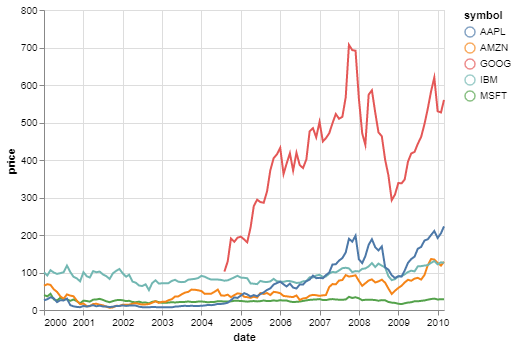

In [12]:
Vega(populated_amz_line)

## Reusing the visualization spec

We can resuse the visualization spec by making some edits.  In this case we are going to load in some
fake data for the pSOFA (pediatric Sequential Organ Failure Assesment) model, which is a an important 
tool in critical care medicine.  

- comprised of subscores (0-4) from 6 organ systems
- assessed in 24 hour intervals, where each patient assessed receives a score of 0-24
- 0 represents the more "normal" end of the neurlogical/physilogical spectrum

Note that the patient identifiers and values are completely made up for purposes of illustration

## How to modify the visualization
- open up a vega editor.  There are several quick ways to do this, including
    + in jupyter lab
    + VS code
    + the online vega editor https://vega.github.io/editor/#/examples/vega-lite/interactive_multi_line_pivot_tooltip
    
- do a find and replace in one of the editors (ctrl f, and toggler the < icon in the popup)
    + replace symbol with identifier
    + replace price with score
    + replace the tooltip channel array symbols with identifiers
    + check to see if it is working by replacing the url in the stocks plot with the psofa_random_data url
    you should see a very busy line plot that has tooltips on hover
    
<img src="images/psofa_1.png" alt="drawing" height= "400" width="300"/>

In [13]:
# data is here
psofa_random_data = "https://raw.githubusercontent.com/baumanab/mlflow_vizmodels_demo/master/data/psofa_random.csv"

**Now let's repeat the process from above**

In [14]:
psofa_line_tooltip_spec_string = \
r"""
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "data": {
    "url": ""
  },
  "width": 400,
  "height": 300,
  "encoding": {"x": {"field": "date", "type": "temporal"}},
  "layer": [
    {
      "encoding": {
        "color": {"field": "identifier", "type": "nominal"},
        "y": {"field": "score", "type": "quantitative"}
      },
      "layer": [
        {"mark": "line"},
        {"transform": [{"filter": {"selection": "hover"}}], "mark": "point"}
      ]
    },
    {
      "transform": [{"pivot": "identifier", "value": "score", "groupby": ["date"]}],
      "mark": "rule",
      "encoding": {
        "opacity": {
          "condition": {"value": 0.3, "selection": "hover"},
          "value": 0
        },
        "tooltip": [
          {"field": "12345", "type": "quantitative"},
          {"field": "2468", "type": "quantitative"},
          {"field": "8282", "type": "quantitative"},
          {"field": "7531", "type": "quantitative"}
        ]
      },
      "selection": {
        "hover": {
          "type": "single",
          "fields": ["date"],
          "nearest": true,
          "on": "mouseover",
          "empty": "none",
          "clear": "mouseout"
        }
      }
    }
  ]
}
"""

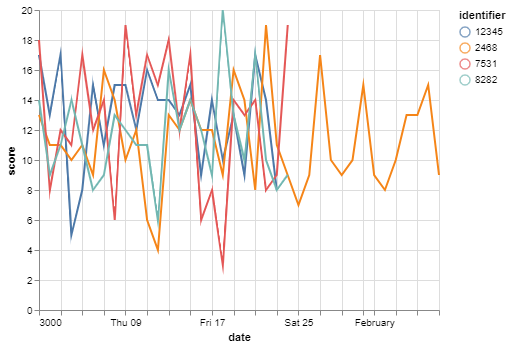

In [15]:
psofa_line = mlflow_vega.styles.vegalite_initial.VGL_VIZ()

psofa_line.transformed_spec = json.loads(psofa_line_tooltip_spec_string)

psofa_line_spec = psofa_line.predict(model_input=psofa_random_data)

Vega(psofa_line_spec)

## What now!

It would be great if we had a way of registering, tracking, and deploying this visualization code. This would enable for easy deployment
to front ends, adpaptation to changing data sources (change pointer or data at the pointer location), and adaptation to changing versions
of the visualization (point to a specific visualization and stage in the MLflow registry, and update the model in the registry vs
updating all of the things that are pointed at it).

Let's walk through an example.

In [16]:
# use a convenience method to create and populate a spec folder
psofa_line.transform(psofa_line_spec)

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.json',
 'data': {'url': ''},
 'width': 400,
 'height': 300,
 'encoding': {'x': {'field': 'date', 'type': 'temporal'}},
 'layer': [{'encoding': {'color': {'field': 'identifier', 'type': 'nominal'},
    'y': {'field': 'score', 'type': 'quantitative'}},
   'layer': [{'mark': 'line'},
    {'transform': [{'filter': {'selection': 'hover'}}], 'mark': 'point'}]},
  {'transform': [{'pivot': 'identifier',
     'value': 'score',
     'groupby': ['date']}],
   'mark': 'rule',
   'encoding': {'opacity': {'condition': {'value': 0.3, 'selection': 'hover'},
     'value': 0},
    'tooltip': [{'field': '12345', 'type': 'quantitative'},
     {'field': '2468', 'type': 'quantitative'},
     {'field': '8282', 'type': 'quantitative'},
     {'field': '7531', 'type': 'quantitative'}]},
   'selection': {'hover': {'type': 'single',
     'fields': ['date'],
     'nearest': True,
     'on': 'mouseover',
     'empty': 'none',
     'clear': 'mouseout'}}}]}

In [17]:
# add a config file to the folder, this is required by the flavor
!echo {} >> spec/config.json

In [18]:
# the flavor will be looking for spec/spec.json and spec/config.json so let's populate the spec and write it
psofa_line.write_spec_file(psofa_line.transformed_spec, 'spec/spec.json')

Now we will register the model and the specification artifacts

In [19]:
os.environ['MLFLOW_TRACKING_URI']='http://localhost:5000'
try:
    mlflow.set_experiment('example')
except Exception as error:
    print(error)
experiment = mlflow.get_experiment_by_name('example')
run_id = str(uuid.uuid4())
with mlflow.start_run(run_name=f'example_{run_id}', experiment_id=experiment.experiment_id) as run:
    model = mlflow_vega.log_model(vega_saved_model_dir='spec', artifact_path='model', registered_model_name="psofa")

INFO: 'example' does not exist. Creating a new experiment


Successfully registered model 'psofa'.
Created version '1' of model 'psofa'.


Navigating to [localhost:5000](localhost:5000) and clicking on models, we can see our visualization model and follow links
to see our the registered artififacts associated with that model.  Try running the code above and creating a few more versions of the model.

Next we will search out and "deploy" a specific version.  Note that we have created but not yet release convenience code for searching
and deploying models from the MLflow registry that is compatible with typical front ends.  We hope to share this in an upcoming 
meetup or blog post.

Now run the code in the cell below.  The following images are examples of the MLflow registry


<img src="images/model_reg_1.png" alt="drawing" width="800" height="1000"/>

---

<img src="images/model_reg_switch.png" alt="drawing" width="800" height="1000"/>

In [22]:
import mlflow.pyfunc
from mlflow.tracking.client import MlflowClient

# instantiate a client and set criteria
client = MlflowClient()

target_version = 1
target_name = 'psofa'
target_stage= 'Production'

try:
    for mv in client.search_model_versions(f"name='{target_name}'"):
        dmv = dict(mv)
        if (dmv.get('version') == str(target_version)) and (dmv.get('name') == target_name) and (dmv.get('current_stage') == target_stage):
            model_source = dmv.get('source')
            loaded_spec = mlflow_vega.load_model(model_source, vega=True)
            
except Exception as err:
    print(err)

In [25]:
# we have pulled the spec
try:
    display(loaded_spec)
except Exception as err:
    print(f'{err}:  Be sure to use the MLflow UI to tag registered version 1 as production and rerun the search code')

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.json',
 'data': {'url': ''},
 'width': 400,
 'height': 300,
 'encoding': {'x': {'field': 'date', 'type': 'temporal'}},
 'layer': [{'encoding': {'color': {'field': 'identifier', 'type': 'nominal'},
    'y': {'field': 'score', 'type': 'quantitative'}},
   'layer': [{'mark': 'line'},
    {'transform': [{'filter': {'selection': 'hover'}}], 'mark': 'point'}]},
  {'transform': [{'pivot': 'identifier',
     'value': 'score',
     'groupby': ['date']}],
   'mark': 'rule',
   'encoding': {'opacity': {'condition': {'value': 0.3, 'selection': 'hover'},
     'value': 0},
    'tooltip': [{'field': '12345', 'type': 'quantitative'},
     {'field': '2468', 'type': 'quantitative'},
     {'field': '8282', 'type': 'quantitative'},
     {'field': '7531', 'type': 'quantitative'}]},
   'selection': {'hover': {'type': 'single',
     'fields': ['date'],
     'nearest': True,
     'on': 'mouseover',
     'empty': 'none',
     'clear': 'mouseout'}}}]}

In [26]:
# call a generic instance of the style for passing data
# future versions of the flavor will handle this in a more elegant fashion
data_pointeromatic_6000 = mlflow_vega.styles.vegalite_initial.VGL_VIZ()

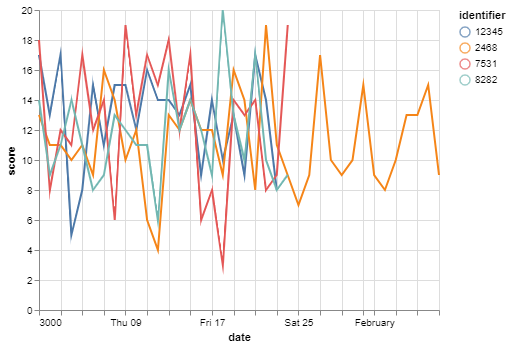

In [27]:
data_pointeromatic_6000.transformed_spec=loaded_spec
populated_spec = data_pointeromatic_6000.predict(model_input=psofa_random_data)
Vega(populated_spec)

### Things to try

- try renaming the data file, altering it, passing it in to the spec and rendering.  Note that intially it's easiest to write data to a public repo and point there.
- alter the model, register it, then redeploy by pointing at that model by changing the search criteria.  Note that we typically use search functions that return the most recently registered model (or an array of models for rendering in a dropdown) given regex search patterns and a stage.

## Now Let's make a multi-layered Geo visualization

### Data

- the most current hospital bed available from Definitive Healthcare: https://opendata.arcgis.com/datasets/1044bb19da8d4dbfb6a96eb1b4ebf629_0.csv 
- the most current county level Covid-19 data: https://raw.githubusercontent.com/nytimes/covid-19-data/master/live/us-counties.csv
- US geo-data

### Data Flow

In Vega/Vegalite we can encode operations in our specification.  We will set the visualization up such that the data flows over it.  Our top level data wil be the hospital data, we will bring in the county and geo data via
lookup transforms.  For the sake of time we are starting with a largely completed visualization and will just be adding/altering elements related to filtering and selection.  In reality we typically build visualizations layer by layer getting user feedback along the way, optimizing encodings, tooltips, size, background, etc. This is one reason why having a visualization registry is so critical, we need to be able to track and swap out versions as well as point to updated data sources.

A note on the efficacy of this visulaization.  This is an interesting visualization that illustrates a layered approach to building from multiple data sources.  Howerver, the Covid data is the sum for all days that data has been collected and doesn't serve the use case of comparing hospital capacity to active covid infections.  We could use a diff on the daily data or other approaches to do this, however, this is a lot for today's talk, so hopefully we can walk through that in the future or leave it to participants to try it on their own.

### Encodings
A quick work on the encodings for bed utilization and number of ICU beds.  The encodings are designed
such that more beds and fewer utilized beds create ever larger and darker circles whereas
less beds and more utilized beds create lighter and smaller circles that fade into the background.

### Missing Data

Note that the blank spots on the map correspond to states our counties whose data did not survive the lookup or is otherwise missing.  Were this a visualization we were actually deploying for use we would need to address this, for today's purposes we will leave that to a future activity.

## Create a Visualization for all states

In [21]:
# entire USA
USA_spec = \
r"""
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 500,
  "height": 300,
  "data": {
    "name": "hospital_beds",
    "url": "https://opendata.arcgis.com/datasets/1044bb19da8d4dbfb6a96eb1b4ebf629_0.csv"
  },
  "transform": [
    {
      "lookup": "FIPS",
      "from": {
        "name": "covid_counties",
        "data": {
          "url": "https://raw.githubusercontent.com/nytimes/covid-19-data/master/live/us-counties.csv"
        },
        "key": "fips",
        "fields": [
          "date",
          "county",
          "state",
          "fips",
          "cases",
          "deaths",
          "confirmed_cases",
          "confirmed_deaths",
          "probable_cases",
          "probable_deaths"
        ]
      }
    },
    {
      "lookup": "FIPS",
      "from": {
        "data": {
          "name": "counties",
          "url": "https://raw.githubusercontent.com/d3/d3-geo/master/test/data/us-10m.json",
          "format": {"type": "topojson", "feature": "counties"}
        },
        "key": "id",
        "fields": ["geometry", "properties"]
      }
    },
    {"filter": "datum.geometry != null"}
  ],
  "layer": [
    {
      "projection": {"type": "albersUsa"},
      "mark": "geoshape",
      "encoding": {
        "shape": {"field": "geometry", "type": "geojson"},
        "fill": {"field": "cases", "type": "quantitative"}
      }
    },
    {
      "projection": {"type": "albersUsa"},
      "mark": {"type": "circle", "tooltip": {"content": "hospital_beds"}},
      "encoding": {
        "longitude": {"field": "X", "type": "quantitative"},
        "latitude": {"field": "Y", "type": "quantitative"},
        "size": {
          "field": "NUM_ICU_BEDS",
          "type": "quantitative",
          "legend": {"orient": "bottom"}
        },
        "color": {
          "field": "BED_UTILIZATION",
          "type": "quantitative",
          "legend": {"orient": "top"},
          "scale": {"range": ["darkred", "lightblue"]}
        }
      }
    }
  ]
}
"""

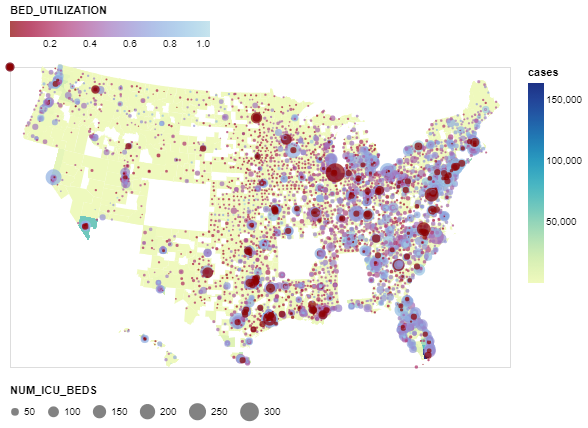

In [22]:
Vega(json.loads(USA_spec))

In [23]:
# filter down to WA
WA_spec = \
r"""
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 500,
  "height": 300,
  "data": {
    "name": "hospital_beds",
    "url": "https://opendata.arcgis.com/datasets/1044bb19da8d4dbfb6a96eb1b4ebf629_0.csv"
  },
  "transform": [
    {
      "lookup": "FIPS",
      "from": {
        "name": "covid_counties",
        "data": {
          "url": "https://raw.githubusercontent.com/nytimes/covid-19-data/master/live/us-counties.csv"
        },
        "key": "fips",
        "fields": [
          "date",
          "county",
          "state",
          "fips",
          "cases",
          "deaths",
          "confirmed_cases",
          "confirmed_deaths",
          "probable_cases",
          "probable_deaths"
        ]
      }
    },
    {
      "lookup": "FIPS",
      "from": {
        "data": {
          "name": "counties",
          "url": "https://raw.githubusercontent.com/d3/d3-geo/master/test/data/us-10m.json",
          "format": {"type": "topojson", "feature": "counties"}
        },
        "key": "id",
        "fields": ["geometry", "properties"]
      }
    },
    {"filter": "datum.geometry != null"}
  ],
  "layer": [
    {
      "transform": [{"filter": "datum.STATE_NAME == 'Washington'"}],
      "projection": {"type": "albersUsa"},
      "mark": "geoshape",
      "encoding": {
        "shape": {"field": "geometry", "type": "geojson"},
        "fill": {"field": "cases", "type": "quantitative"}
      }
    },
    {
      "projection": {"type": "albersUsa"},
      "mark": {"type": "circle", "tooltip": {"content": "hospital_beds"}},
      "encoding": {
        "longitude": {"field": "X", "type": "quantitative"},
        "latitude": {"field": "Y", "type": "quantitative"},
        "size": {
          "field": "NUM_ICU_BEDS",
          "type": "quantitative",
          "legend": {"orient": "bottom"}
        },
        "color": {
          "field": "BED_UTILIZATION",
          "type": "quantitative",
          "legend": {"orient": "top"},
          "scale": {"range": ["darkred", "lightblue"]}
        }
      },
      "transform": [{"filter": "datum.STATE_NAME == 'Washington'"}]
    }
  ]
}
"""

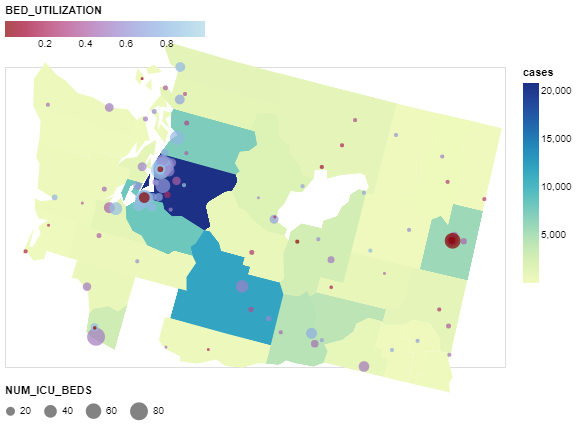

In [24]:
Vega(json.loads(WA_spec))

In [25]:
# add selection by State
state_selection_spec = \
r"""
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 500,
  "height": 300,
  "data": {
    "name": "hospital_beds",
    "url": "https://opendata.arcgis.com/datasets/1044bb19da8d4dbfb6a96eb1b4ebf629_0.csv"
  },
  "transform": [
  {
      "lookup": "FIPS",
      "from": {
        "name": "covid_counties",
        "data": {"url": "https://raw.githubusercontent.com/nytimes/covid-19-data/master/live/us-counties.csv"},
        
        "key": "fips",
        "fields": ["date","county","state","fips","cases","deaths","confirmed_cases","confirmed_deaths","probable_cases","probable_deaths"]
      }
    },
    {"lookup": "FIPS",
     "from": {
       "data": {
    "name": "counties",
    "url": "https://raw.githubusercontent.com/d3/d3-geo/master/test/data/us-10m.json",
    "format": {
      "type": "topojson",
      "feature": "counties"
          }},
        "key": "id",
        "fields": ["geometry", "properties"]
          }
    },
  { "filter": "datum.geometry != null"}
  ],
  "layer": [
  {
  "transform": [{"filter": {"selection": "State"}}],"projection": {"type": "albersUsa"},
  "mark": "geoshape",     
  "encoding": {"shape": {"field": "geometry", "type": "geojson"},
   "fill": {
        "field": "cases",
        "type": "quantitative"
      }}},
  {"selection": {
      "State": {
        "type": "single", "fields": ["state"],
        "init": {"state": "Washington"},
        "bind": {
          "state": {"input": "single"}
        }
      }},"projection": {
            "type": "albersUsa"
          },
          "mark": {"type": "circle", 
                  "tooltip":{"content": "hospital_beds"}
                  },
          "encoding": {
            "longitude": {
              "field": "X",
              "type": "quantitative"
            },
            "latitude": {
              "field": "Y",
              "type": "quantitative"
            },
            "size": {"field": "NUM_ICU_BEDS", 
                    "type": "quantitative",
                    "legend": {"orient": "bottom"}},
            "color": {"field": "BED_UTILIZATION", 
                      "type": "quantitative",
                      "legend": {"orient": "top"},
                      "scale": {"range": ["darkred", "lightblue"]}
                    }      
          },
          "transform": [{"filter": {"selection": "State"}}]
          
        }]
}
"""

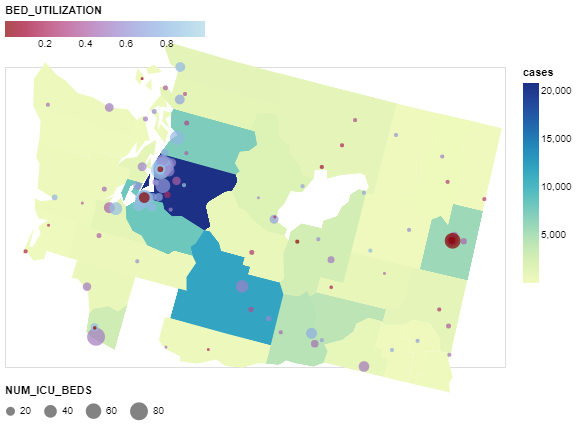

In [26]:
Vega(json.loads(state_selection_spec))

## Push the specs to the visualization registry

We are going to push these spces with the top level data element intact.  If we wanted to change the data element during deployment we could
use a slight modification of the pattern we used for pSOFA.

In [27]:
hospital_named_data_element = {'name': 'some_new_name',
  'url': 'some_new_data_path'}

In [28]:
data_pointeromatic_6000.transformed_spec = json.loads(USA_spec)
populated_spec = data_pointeromatic_6000.predict(model_input=hospital_named_data_element, replace_data_value=True)
populated_spec

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.json',
 'width': 500,
 'height': 300,
 'data': {'name': 'some_new_name', 'url': 'some_new_data_path'},
 'transform': [{'lookup': 'FIPS',
   'from': {'name': 'covid_counties',
    'data': {'url': 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/live/us-counties.csv'},
    'key': 'fips',
    'fields': ['date',
     'county',
     'state',
     'fips',
     'cases',
     'deaths',
     'confirmed_cases',
     'confirmed_deaths',
     'probable_cases',
     'probable_deaths']}},
  {'lookup': 'FIPS',
   'from': {'data': {'name': 'counties',
     'url': 'https://raw.githubusercontent.com/d3/d3-geo/master/test/data/us-10m.json',
     'format': {'type': 'topojson', 'feature': 'counties'}},
    'key': 'id',
    'fields': ['geometry', 'properties']}},
  {'filter': 'datum.geometry != null'}],
 'layer': [{'projection': {'type': 'albersUsa'},
   'mark': 'geoshape',
   'encoding': {'shape': {'field': 'geometry', 'type': 'geojson'

In [29]:
geo_specs = {'geo_usa_spec': USA_spec, 'geo_wa_spec': WA_spec, 'state_select_spec': state_selection_spec}

In [30]:
geo_vg = mlflow_vega.styles.vegalite_initial.VGL_VIZ()

In [31]:
geo_vg.transformed_spec = json.loads(geo_specs.get('geo_usa_spec'))

In [32]:
REG_MODEL_NAME = 'geo_examples'

for geo_spec_name, geo_spec in geo_specs.items():
    
    geo_vg.transformed_spec = json.loads(geo_spec)
    geo_vg.write_spec_file(spec_to_write=geo_vg.transformed_spec, write_path='spec/spec.json')
    
    try:
        mlflow.set_experiment('geo_examples')
    except Exception as error:
        print(error)
    
    experiment = mlflow.get_experiment_by_name('geo_examples')

    with mlflow.start_run(experiment_id=experiment.experiment_id) as run:
        model = mlflow_vega.log_model(vega_saved_model_dir='spec', artifact_path='model', registered_model_name=f'{REG_MODEL_NAME}')

INFO: 'geo_examples' does not exist. Creating a new experiment


Successfully registered model 'geo_examples'.
Created version '1' of model 'geo_examples'.
Registered model 'geo_examples' already exists. Creating a new version of this model...
Created version '2' of model 'geo_examples'.
Registered model 'geo_examples' already exists. Creating a new version of this model...
Created version '3' of model 'geo_examples'.


### Navigate to the MLflow UI and change version 2 to staging and version 3 to production before running the cell below

In [34]:
statuses = ['None', 'Staging', 'Production']
version = 1
retrieved_specs = list()

# instantiate a client
client = MlflowClient()

for status in statuses:
    
    target_version = version
    target_name = 'geo_examples'
    target_stage= status

    try:
        for mv in client.search_model_versions(f"name='{target_name}'"):
            dmv = dict(mv)
            if (dmv.get('version') == str(target_version)) and (dmv.get('name') == target_name) and (dmv.get('current_stage') == target_stage):
                model_source = dmv.get('source')
                loaded_spec = mlflow_vega.load_model(model_source, vega=True)
                retrieved_specs.append(loaded_spec)
                version += 1
    except Exception as err:
        print(err)

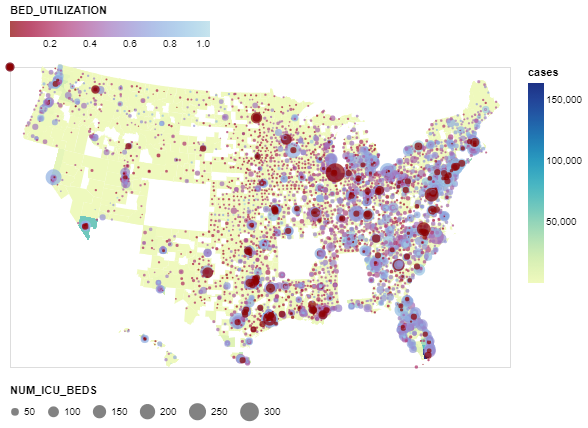

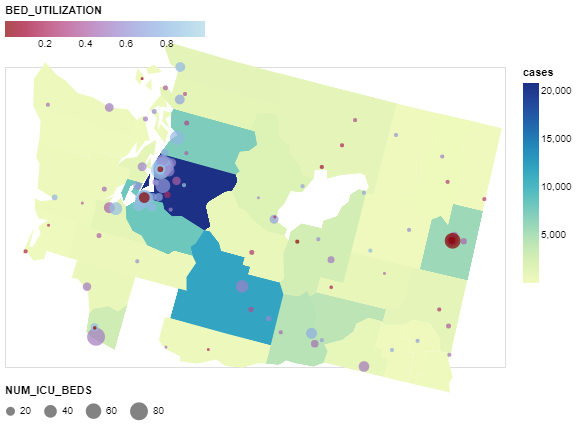

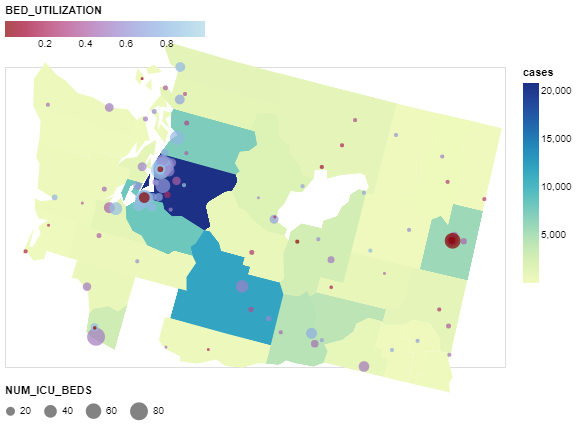

[None, None, None]

In [35]:
[Vega(retrieved_spec) for retrieved_spec in retrieved_specs]

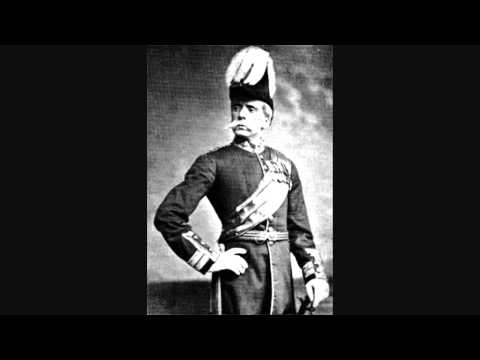

In [36]:
# TODO: Add Rick Roll :)
from IPython.display import YouTubeVideo

YouTubeVideo('Z2OcbeGqbpU')